# Data Preprocessing

Joeri R. Hermans                    
*Departement of Data Science & Knowledge Engineering*          
*Maastricht University, The Netherlands*                

In this notebook we mainly deal with the preprocessing of the physics datasets that have been handed to us. We prepare them in such a way that they are ready for ML problems. Furthermore, in order to have complete information at a later stage, we maintain the "old" information as well. This includes all the extracted parameters of the tracks that have been reconstructed by offline software.

In [1]:
%matplotlib inline

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import numpy as np

from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import Row

from distkeras.utils import *
from distkeras.transformers import *

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0,com.databricks:spark-avro_2.11:3.2.0 pyspark-shell'

Using TensorFlow backend.


In [2]:
# Modify these variables according to your needs.
application_name = "CMS Event Preprocessing"
using_spark_2 = False
local = False
path_data = "data/events.csv"
if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_processes = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 20
    num_processes = 4

# This variable is derived from the number of cores and executors,
# and will be used to assign the number of model trainers.
num_workers = num_executors * num_processes

print("Number of desired executors: " + `num_executors`)
print("Number of desired processes / executor: " + `num_processes`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 20
Number of desired processes / executor: 4
Total number of workers: 80


In [3]:
# Do not change anything here.
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_processes`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "5g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set("spark.kryoserializer.buffer.max.mb", "2000")
#conf.set("spark.executor.heartbeatInterval", "3600s")
conf.set("spark.akka.frameSize", "128")
#conf.set("spark.akka.timeout", "200s")
#conf.set("spark.akka.heartbeat.interval", "60s")
conf.set("spark.shuffle.spill","true")
conf.set("spark.driver.memory", "7g")

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
                     .appName(application_name) \
                     .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [4]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
dataset = reader.read.format('com.databricks.spark.csv') \
                .options(header='true', inferSchema='true') \
                .load(path_data)
# Remove the empty column name.
columns = dataset.columns
del columns[0]
dataset = dataset.select(columns)
# Repartition the dataset.
dataset = dataset.repartition(num_workers)
dataset.cache()

# Count the total number of events.
print("Total number of tracks: " + str(dataset.count()))

Total number of tracks: 1747413


In [5]:
# Fetch the number of different event labels.
distinct_labels = dataset.select(dataset.label).distinct()
distinct_labels.cache()
raw_labels = distinct_labels.collect()
num_labels = distinct_labels.count()
labels = {}
for i in range(0, len(raw_labels)):
    label = raw_labels[i]['label']
    labels[label] = i

print("Labels: " + str(labels))
print("Number of labels: " + str(num_labels))

Labels: {u'RSGravitonToGaGa': 3, u'PhiToMuMu': 4, u'Wjet': 0, u'H125GGgluonfusion': 5, u'DisplacedSUSY_stopToBottom': 2, u'SMS-T1tttt_mGl': 1}
Number of labels: 6


In [6]:
def construct_keys(row):
    run = row['run']
    event = row['evt']
    luminosity = row['lumi']
    key = str(run) + '-' + str(event) + '-' + str(luminosity)
    
    return Row(**{'id': key, 'tracks': [row]})

track_keys = dataset.map(construct_keys)
collision_tracks = track_keys.reduceByKey(lambda a, b: a + b).map(lambda x: Row(**{'id': x[0], 'tracks': x[1]})).toDF()
collision_tracks.cache()
print("Number of collisions with tracks: " + str(collision_tracks.count()))

Number of collisions with tracks: 16358


The following cell defines a function which will obtain the particle hits from a track, as registered by the CMS detector. The columns which have a `pix` prefix are the hits extracted from the [silicon pixel detector](http://cms.web.cern.ch/news/silicon-pixels). Whereas the columns with a `sis` prefix are the particle hits extracted from the [silicon strips](http://cms.web.cern.ch/news/silicon-strips).

In [7]:
def obtain_hits(track):
    hits = []
    # Remove the pixel detector hits.
    for i in range(0, 5):
        column = "pix_" + str(i)
        c_x = column + "_x"
        x = track[c_x]
        c_y = column + "_y"
        y = track[c_y]
        c_z = column + "_z"
        z = track[c_z]
        if x == 0.0 or y == 0.0 or z == 0.0:
            break
        hits.append([x, y, z])
    # Remove the silicon detector hits.
    for i in range(0, 50):
        column = "sis_" + str(i)
        c_x = column + "_x"
        x = track[c_x]
        c_y = column + "_y"
        y = track[c_y]
        c_z = column + "_z"
        z = track[c_z]
        if x == 0.0 or y == 0.0 or z == 0.0:
            break
        hits.append([x, y, z])
    
    return hits

In [8]:
def construct_feature_matrix_front(tracks):
    # Define the front matrix with the specified granularity.
    granularity = 1.0
    unit = 1.0 / granularity
    size_x = int((320.0 / granularity) + 1)
    size_y = int((240.0 / granularity) + 1)
    middle_x = size_x / 2 - 1
    middle_y = size_y / 2 - 1
    m = np.zeros((size_y, size_x))
    # Add the tracks to the matrix.
    for track in tracks:
        hits = np.asarray(obtain_hits(track))
        for hit in hits:
            x = int((hit[0] * unit) + middle_x)
            y = -int((hit[1] * unit) + middle_y)
            m[y][x] += 1.0
            
    return m

In [9]:
def construct_feature_matrix_side(tracks):
    # Define the side matrix with the specified granularity
    granularity = 1.0
    unit = 1.0 / granularity
    size_x = int((600.0 / granularity) + 1)
    size_y = int((300.0 / granularity) + 1)
    middle_x = size_x / 2 - 1
    middle_y = size_y / 2 - 1
    m = np.zeros((size_y, size_x))
    # Add the tracks to the matrix.
    for track in tracks:
        hits = np.asarray(obtain_hits(track))
        for hit in hits:
            x = int((hit[2] * unit) + middle_x)
            y = -int((hit[1] * unit) + middle_y)
            m[y][x] += 1.0
    
    return m

In [10]:
def construct_feature_matrix_volume(tracks):
    # TODO Implement.
    pass

In [11]:
def normalize_feature_matrix(x):
    max_value = x.max()
    
    return np.divide(x, max_value)

In [13]:
def format_instances(x):
    # Obtain the tracks.
    tracks = x[1]
    # Construct label vector.
    label_vector = np.zeros(num_labels)
    for track in tracks:
        label = track['label']
        index = labels[label]
        label_vector[index] = 1.0
    # Construct the front feature matrices.
    front = construct_feature_matrix_front(tracks)
    front_flat = front.flatten()
    front_normalized = normalize_feature_matrix(front)
    front_normalized_flat = front_normalized.flatten()
    # Construct the side feature matrices.
    side = construct_feature_matrix_side(tracks)
    side_flat = side.flatten()
    side_normalized = normalize_feature_matrix(side)
    side_normalized_flat = side_normalized.flatten()
    
    # .tolist() for NumPy arrays to make Spark a happy program.
    return Row(**{"id": x[0], \
                  "front": front.tolist(), \
                  "front_flat": front_flat.tolist(), \
                  "front_normalized": front_normalized.tolist(), \
                  "front_normalized_flat": front_normalized_flat.tolist(), \
                  "side": side.tolist(), \
                  "side_flat": side_flat.tolist(), \
                  "side_normalized": side_normalized.tolist(), \
                  "side_normalized_flat": side_normalized_flat.tolist(), \
                  "label": label_vector.tolist()})

In [14]:
def format_tracks(x):
    run = x['run']
    event = x['evt']
    luminosity = x['lumi']
    id = str(run) + "-" + str(event) + "-" + str(luminosity)
    d = x.asDict()
    d['collision_id'] = id
    
    return Row(**d)

In [15]:
# Write the tracks to HDFS for later use.
df = dataset.map(format_tracks).toDF()
df.write.format("com.databricks.spark.avro").save("data/tracks.avro")

In [16]:
# Construct the training data.
df = collision_tracks.map(format_instances).toDF()
# Obtain the matrix rows and columns of a feature matrix.
matrix_rows_front, matrix_cols_front = np.asarray(df.take(1)[0]['front']).shape
matrix_rows_side, matrix_cols_side = np.asarray(df.take(1)[0]['side']).shape
# Next, prepare the dataset for the convolutional networks.
rt_f = ReshapeTransformer("front", "front_reshaped", (matrix_rows_front, matrix_cols_front, 1))
rt_s = ReshapeTransformer("side", "side_reshaped", (matrix_rows_side, matrix_cols_side, 1))
df = rt_f.transform(df)
df = rt_s.transform(df)
# Write the dataframe to HDFS.
df.write.format("com.databricks.spark.avro").save("data/collisions.avro")

In [17]:
def display_front_tracks(tracks):
    num_tracks = len(tracks)
    for i in range(0, num_tracks):
        hits = np.asarray(obtain_hits(tracks[i]))
        x = hits[:, 0]
        y = hits[:, 1]
        plt.scatter(x, y, 0.3)
    plt.grid(False)
    plt.xlim([-160, 160])
    plt.ylim([-120, 120])
    #plt.title("Front view CMS pixel and silicon detector")
    plt.show()

def display_side_tracks(tracks):
    num_tracks = len(tracks)
    for i in range(0, num_tracks):
        hits = np.asarray(obtain_hits(tracks[i]))
        y = hits[:, 1]
        z = hits[:, 2]
        plt.scatter(z, y, 0.3)
    plt.grid(False)
    plt.xlim([-300, 300])
    plt.ylim([-160, 160])
    #plt.title("Side view CMS detector")
    plt.show()

In [18]:
tracks = reader.read.format("com.databricks.spark.avro").load("data/tracks.avro")
tracks.select(tracks.collision_id).take(1)

[Row(collision_id=u'1-1719-35')]

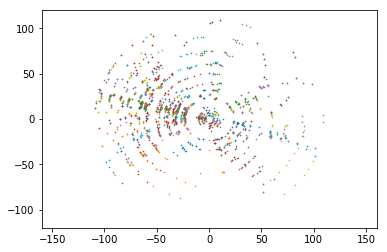

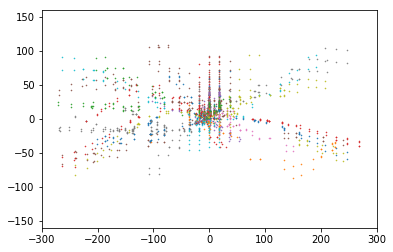

In [19]:
collision_id = '1-6769-136'
# Fetch the tracks from the specified collision id.
examples = tracks.filter(tracks.collision_id == collision_id).collect()
# View the hits of the front of the detector, and the side.
display_front_tracks(examples)
display_side_tracks(examples)

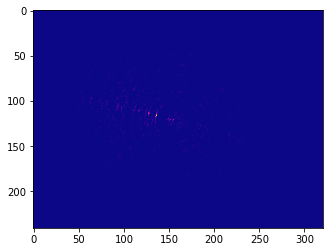

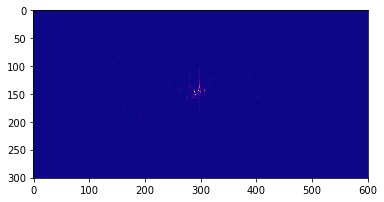

In [25]:
# Plot the feature matrix with the same collision id.
collisions = reader.read.format("com.databricks.spark.avro").load("data/collisions.avro")
collision = collisions.filter(collisions.id == collision_id).collect()[0]
m_front = np.asarray(collision['front'])
m_side = np.asarray(collision['side'])
# View front feature matrix.
plt.imshow(m_front, cmap='plasma', interpolation='nearest')
plt.show()
# View side feature matrix.
plt.imshow(m_side, cmap='plasma', interpolation='nearest')
plt.show()